# Final version for ball detection

* all old versions are in backup_notebooks.py or detect_ball_thresh.py
* this version: employ metric including area differences, slope, distance, angle diagonals of rectangle
* search in graph for moment when this metric is smaller the threshold

In [1]:
import cv2
import math
from matplotlib import pyplot as plt
import numpy as np
import os
import time
import json
import pandas as pd
%matplotlib inline

def from_json(file):
    coordinates = ["x", "y"]
    joints_list = ["right_shoulder", "right_elbow", "right_wrist", "left_shoulder","left_elbow", "left_wrist",
            "right_hip", "right_knee", "right_ankle", "left_hip", "left_knee", "left_ankle",
            "right_eye", "right_ear","left_eye", "left_ear", "nose ", "neck"]
    with open(file, 'r') as inf:
        out = json.load(inf)

    liste = []
    for fr in out["frames"]:
        l_joints = []
        for j in joints_list[:12]:
            l_coo = []
            for xy in coordinates:
                l_coo.append(fr[j][xy])
            l_joints.append(l_coo)
        liste.append(l_joints)

    return np.array(liste)

def get_slope(center1, center2):
    y_diff = (center1[1]-center2[1])
    slope = np.arctan(y_diff/(center1[0]-center2[0]))
    if y_diff < 0:
        slope+= np.pi
    return slope

class Node():
    def __init__(self, x1, y1, x2, y2):
        self.bbox = [x1, y1, x2, y2]
        self.l = abs(x1-x2)
        self.w = abs(y1-y2)
        self.angle = np.arctan(self.l/self.w)
        self.area = self.l*self.w # (l+w)/float(l*w)
        self.center = np.array([(x1+x2)/2, (y1+y2)/2])
        self.children = []
        self.area_diffs = []
        self.angle_diffs = []
        self.slopes = []
        self.dist = []
    def add_child(self, no):
        dist = np.linalg.norm(no.center-self.center)
        if dist>10: 
            self.children.append(no)
            self.area_diffs.append(abs(1-(no.area/self.area)))
            self.slopes.append(get_slope(self.center, no.center))
            self.dist.append(dist)
            self.angle_diffs.append(abs(self.angle-no.angle))
    def favourite_child(self, no):
        self.fav_child=no
        

In [101]:
def get_difference(im_tm1, im_t, im_tp1):
    """
    calculates difference image and applies threshold to detect significant motion
    parameters: three consecutive frames
    returns binary image of same size as input frames indicating significantly different pixels
    """
    delta_plus = cv2.absdiff(im_t, im_tm1)
    delta_0 = cv2.absdiff(im_tp1, im_tm1)
    delta_minus = cv2.absdiff(im_t,im_tp1)
    sp = cv2.meanStdDev(delta_plus)
    sm = cv2.meanStdDev(delta_minus)
    s0 = cv2.meanStdDev(delta_0)
    # print("E(d+):", sp, "\nE(d-):", sm, "\nE(d0):", s0)

    th = [
        sp[0][0, 0] + 3 * math.sqrt(sp[1][0, 0]),
        sm[0][0, 0] + 3 * math.sqrt(sm[1][0, 0]),
        s0[0][0, 0] + 3 * math.sqrt(s0[1][0, 0]),
    ]

    # OPENCV THRESHOLD

    ret, dbp = cv2.threshold(delta_plus, th[0], 255, cv2.THRESH_BINARY)
    ret, dbm = cv2.threshold(delta_minus, th[1], 255, cv2.THRESH_BINARY)
    ret, db0 = cv2.threshold(delta_0, th[2], 255, cv2.THRESH_BINARY)

    detect = cv2.bitwise_and(cv2.bitwise_and(dbp, dbm), cv2.bitwise_not(db0))
    # nd = cv2.bitwise_not(detect)
    return detect


def get_candidates(nd, min_area):
    """
    find connected components in a binary difference image
    nd is a binary image indicating significant pixel changes
    min_area is the minimum area of pixels in nd that should be recognized as a connected region
    return list of candidates, each is a tuple (left_top_corner, right_bottom_corner, area)
    """
    # only stats is used, not num, labels, centroids
    num, labels, stats, centroids = cv2.connectedComponentsWithStats(nd, ltype=cv2.CV_16U)
    # We set an arbitrary threshold to screen out smaller "components"
    # which may result simply from noise, or moving leaves, and other
    # elements not of interest.
    candidates = list()
    for stat in stats[1:]:
        area = stat[cv2.CC_STAT_AREA]
        if area < min_area:
            continue # Skip small objects (noise)

        lt = (stat[cv2.CC_STAT_LEFT], stat[cv2.CC_STAT_TOP])
        rb = (lt[0] + stat[cv2.CC_STAT_WIDTH], lt[1] + stat[cv2.CC_STAT_HEIGHT])
        #if np.any(np.array(lt)==0) or np.any(np.array(rb)==0):
         #   continue
        bottomLeftCornerOfText = (lt[0], lt[1] - 15)

        candidates.append((lt, rb, area))
    return candidates


def first_movement(cand_list, joints, ankle_move, fr):
    knees= joints[[7, 10],:]
    ankles = joints[[8,11],:]
    #print(knees, ankles, knees-ankles, np.mean(knees-ankles, axis=0))
    dist_ankle = np.linalg.norm(np.mean(knees-ankles, axis=0)) #//2
    #print("radius", dist_ankle)
    for k, cand in enumerate(cand_list):
        x1, y1 = cand[0]
        x2, y2 = cand[1]
        center = [(x1+x2)/2, (y1+y2)/2]
              #np.linalg.norm(cand.center - knees[0]), 
            #np.linalg.norm(cand.center - knees[1]), np.linalg.norm(cand.center - ankles[1]), 
                #                                     np.linalg.norm(cand.center - ankles[0]))
        #print(np.linalg.norm(cand.center - knees[0])<radius, np.linalg.norm(cand.center - knees[1])<radius)
        norms = np.array([np.linalg.norm(center - knees[0]), np.linalg.norm(center - knees[1]), np.linalg.norm(center - ankles[0]), np.linalg.norm(center - ankles[1])])
        #print("center", cand.center, "knees", knees[0],knees[1], "ankles", ankles, "norms", norms)
        if np.any(norms<dist_ankle):
            # print("smaller radius", center)
            ankle_move.append(fr) #cand.center)
            break
    return ankle_move
        #if k==len(candidates_per_frame[-1])-1:
         #   ankle_move=[]
    #print(t, ankle_move)

def plot(im_t, candidates, frame_nr):
    #print("DETECTED", t-1, whiteness_values[-1], candidate_values[-1])
    plt.figure(figsize=(10, 10), edgecolor='r')
    # print(candidates[fom])
    img = np.tile(np.expand_dims(im_t.copy(), axis = 2), (1,1,3))
    #print(img.shape)
    #for jo in ankles:
     #   cv2.circle(img, (int(jo[0]), int(jo[1])), 8, [255,0,0], thickness=-1)
    #for kn in knees:
     #   cv2.circle(img, (int(kn[0]), int(kn[1])), 8, [255,0,0], thickness=-1)
    # cv2.circle(img, (690, 290),8, [255,0,0], thickness=-1)
    # cv2.circle(img, (50, 400), 8, [255,0,0], thickness=-1)
    for can in candidates: # einfuegen falls alles plotten
        cv2.rectangle(img, can[0], can[1],[255,0,0], 4)
    #cv2.rectangle(img,tuple(balls[-1][:2]), tuple(balls[-1][2:]), [255,0,0], 4)
    plt.imshow(img, 'gray')
    # plt.axis("off")
    plt.title("Detected FMO frame"+ str(frame_nr)) #+str(candidates))
    # plt.savefig("first_move_sequence/"+bsp[:-4]+"_"+str(frame_nr)) # [:400,200:700]
    # plt.savefig("/Users/ninawiedemann/Desktop/BA/fmo detection/connected_components", pad_inches=0)
    plt.show()
    # print(candidates)


def add_candidate(candidate, candidates_per_frame):
    # The first two elements of each `candidate` tuple are
    # the opposing corners of the bounding box.
    x1, y1 = candidate[0]
    x2, y2 = candidate[1]
    no = Node(x1, y1, x2, y2)
    #print("area_cand[3]:", candidate[2], "area node", no.area)
    candidates_per_frame[-1].append(no)
    if candidates_per_frame[-2]!=[]:
        for nodes_in in candidates_per_frame[-2]:
            nodes_in.add_child(no)
            # print("previous detection", nodes.bbox, "gets child", no.bbox)
    return candidates_per_frame

def ball_detection(candidates_per_frame, balls, metric_thresh =0.5):
    if len(balls)==0:
        for cands3 in candidates_per_frame[-3]:
            for j, cands2 in enumerate(cands3.children): # counts through children (ebene 2)
                slope = cands3.slopes[j] # slope of 3 to 2
                dist = cands3.dist[j]
                area = cands3.area_diffs[j]
                angle = cands3.angle_diffs[j]
                # print("j", j, slope, dist, area, angle)
                for k, cands1 in enumerate(cands2.children):
                    #print("k", k, cands2.slopes[k], cands2.dist[k], cands2.area_diffs[k], cands2.angle_diffs[k])
                    #print("metric: ", abs(slope-cands2.slopes[k]), abs(1- dist/cands2.dist[k]), area, cands2.area_diffs[k])
                    metric = abs(slope-cands2.slopes[k]) + abs(1- dist/cands2.dist[k]) #+ area+cands2.area_diffs[k] + angle + cands2.angle_diffs[k] 
                    if metric<metric_thresh:
                        balls = [cands3, cands2, cands1]
                        metric_thresh = metric
                    # if abs(slope-cands2.slopes[k]) < 0.1 and abs(dist-cands2.dist[k])<10:
    else:
        j = balls[-2].children.index(balls[-1])
        slope = balls[-2].slopes[j] # slope of 3 to 2
        dist = balls[-2].dist[j]
        area = balls[-2].area_diffs[j]
        angle = balls[-2].angle_diffs[j]
        new_ball = None
        for k, cands1 in enumerate(balls[-1].children):
            #print("k", k, balls[-1].slopes[k], balls[-1].dist[k], balls[-1].area_diffs[k], balls[-1].angle_diffs[k])
            #print("metric: ", abs(slope-balls[-1].slopes[k]), abs(1- dist/balls[-1].dist[k]), area, balls[-1].area_diffs[k])
            metric = abs(slope-balls[-1].slopes[k]) + abs(1- dist/balls[-1].dist[k]) # + area+balls[-1].area_diffs[k] + angle + balls[-1].angle_diffs[k] 
            if metric<metric_thresh:
                new_ball = cands1
                metric_thresh = metric
        if new_ball is None:
            balls = []
        else:
            balls.append(new_ball)
            # if abs(slope-cands2.slopes[k]) < 0.1 and abs(dist-cands2.dist[k])<10:
    return balls

def distance_projected(p, p1,p2):
    """
    returns distance of p' (= p projected on line spanned by p1 and p2) from p1
    """
    v1 = p-p1
    v2 = p2-p1
    v1_u = v1 / np.linalg.norm(v1)
    v2_u = v2 / np.linalg.norm(v2)
    return np.clip(np.dot(v1_u, v2_u), -1.0, 1.0) * np.linalg.norm(v1)

def _get_max_array(array_list):
    """
    returns union of the binary images in array_list
    """
    resultant_array = np.zeros(array_list[0].shape)
    for array in array_list:
        resultant_array = np.maximum(resultant_array, array)
    return resultant_array

def release_frame(balls, t, images=None):
    trajectory = np.array([elem.center for elem in balls]).astype(int)
    nr_balls = len(trajectory)
    dist_from_start = distance_projected(trajectory[0], np.array([110, 140]),np.array([690, 288]))
    speed = np.mean([np.linalg.norm(trajectory[i]- trajectory[i+1]) for i in range(nr_balls-1)])
    frames_shifted = int(round(dist_from_start/speed + len(balls)-1)) # frames because current frame is already after nth ball detection
    # print(dist_from_start, speed, frames_shifted)
    ball_release = t - frames_shifted
    if images is None:
        return ball_release
    
    plt.figure(figsize=(10,5))
    if frames_shifted >10:
        print("ATTENTION: image does not correspond to release frame, but to", frames_shifted-10, 
              "frames after release frame - image was not saved in buffer anymore")
        frames_shifted = 10
    # box = np.array(balls[0].bbox) - 80
    img = images[-frames_shifted]# [80:180,80:200]
    #img = np.tile(np.expand_dims(im_t.copy(), axis = 2), (1,1,3))
    #cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]),[255,0,0], 1)
    plt.imshow(img)
    plt.title("release frame" +str(ball_release))
    plt.gray()
    plt.axis("off")
    plt.show()
        # plt.savefig("/Users/ninawiedemann/Desktop/BA/release_frame evaluation/"+str(ball_release))
    return ball_release
    
def trajectory_and_speed(trajectory, fps = 30, factor_pixel_feet=10, plotting=True):
    trajectory = np.asarray(trajectory)
    # print(trajectory)
    distances = []
    for i in range(len(trajectory)-1):
        frame_difference = trajectory[i+1, 2] - trajectory[i,2]
        dist_difference = np.linalg.norm(trajectory[i,:2]- trajectory[i+1, :2])
        distances.append(dist_difference/frame_difference)
    speed = np.mean(distances)
    if plotting:
        plt.figure(figsize=(10, 5), edgecolor='r')
        plt.scatter(trajectory[:, 0], trajectory[:,1])
        plt.title("speed in mph: "+ str(speed*fps* 0.681818 /factor_pixel_feet))
        plt.ylim(400,0)
        plt.xlim(0,800)
        plt.show()
    mph = speed*fps* 0.681818 /factor_pixel_feet
    return mph

In [102]:
def detect_ball(folder, joints_array=None, min_area = 400, plotting=True, min_length_first=5, every_x_frame=1, roi=None):
    """
    roi: region of interest if not the whole frame is relevant, format: list [top, bottom, left, right] with top<bottom
    """
    fps = 30
    factor_pixel_feet = 10
    cap = cv2.VideoCapture(folder)
    images=[]
    motion_images=[]
    start = time.time()

    candidates_per_frame = []
    location = []
    frame_indizes = []
    ankle_move=[]
    balls = []
    t=0 # frame count
    first_move_found = False
    ball_release_found = False

    # function returns
    ball_release = 0 # if not found
    first_move_frame = 0 # if not found
    ball_trajectory = []
    tocs = []#
    tocs2 = []
    tocs3 = []
    balls_per_frame = []
    while True:
        ret, frame = cap.read()
        if frame is None:
            break
        
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        if roi is not None:
            frame = frame[roi[0]:roi[1], roi[2]:roi[3]]
        
        tic2 = time.time()
        while t<11:
            if t>1:
                im_tm1 = images[-2]
                im_t = images[-1]
                im_tp1 = frame

                nd = get_difference(im_tm1, im_t, im_tp1)
                if t<11:
                    motion_images.append(nd)
            images.append(frame)
            candidates_per_frame.append([])
            t+=1
        
        candidates_per_frame.append([])
        im_tm1 = images[-2]
        im_t = images[-1]
        im_tp1 = frame

        nd = get_difference(im_tm1, im_t, im_tp1)
            
        tic = time.time()
        im_every_x_0 = images[-2*every_x_frame]
        im_every_x_1 = images[-every_x_frame]
        im_every_x_2 = images[-1]

        
        cumulative_motion = _get_max_array(motion_images)
        final_frame = nd.astype(int) - cumulative_motion.astype(int)
        final_frame[final_frame < 0] = 0
        # final_frame = nd
        
        candidates = get_candidates(final_frame.astype(np.uint8), min_area)
        
        balls_per_frame.append(len(candidates))
        
        # NORMAL CANDIDATES (THREE IN A ROW)
        # candidates = get_candidates(im_tm1, im_t, im_tp1, min_area)
        #plt.figure(figsize=(10, 10), edgecolor='k')
    

        ### HERE INSERT RELEASE FRAME CLOSE TO WRIST
        
        for i, candidate in enumerate(candidates):
            if t>0:
                candidates_per_frame = add_candidate(candidate, candidates_per_frame)
            ### HERE INSERT CLOSE TO WRIST
            ### HERE INSERT SHORTEST PATH CODE
            #save location of candidate and frame
            #location.append(center)
            frame_indizes.append(t-1)
        
        
        ### BALL DETECTION:
        l = np.array([len(candidates_per_frame[-i-1]) for i in range(3)])
        if np.all(l>0) and len(balls)==0:
            balls = ball_detection(candidates_per_frame, balls)
            
            if len(balls)==3 and not ball_release_found:
                ball_release_found = True
                ball_release = release_frame(balls, t) #, images = images)               
        elif len(balls)>0: # already balls detected
            if len(candidates_per_frame)>0:
                new_balls = ball_detection(candidates_per_frame, balls)
            else:
                new_balls = []
            # no further detections: add to ball_trajectory list
            if len(new_balls)==0:
                # mph = trajectory_and_speed(balls, im_t, t-1)
                mean_slope = np.mean(np.array([get_slope(balls[i].center, balls[i+1].center) for i in range(len(balls)-1)]))
                if len(ball_trajectory)!=0:
                    mean_slope_previous = np.mean(np.array([get_slope(ball_trajectory[i], ball_trajectory[i+1]) for i in range(len(ball_trajectory)-1)]))
                else:
                    mean_slope_previous = mean_slope
                # print("slopes", mean_slope, mean_slope_previous)
                if abs(mean_slope-mean_slope_previous)<0.1:
                    for i, b in enumerate(balls):
                        frame_count = len(balls)-i
                        ball_trajectory.append([b.center[0], b.center[1], t-1-frame_count])
                    
                balls = []
                # break
            else:
                balls = new_balls
                # break
        else:
            balls=[]
        

        tocs2.append(time.time()-tic2)
        # FIRST MOVEMENT --> SHIFtED CANDIDATES
        tic3 = time.time()
        if not first_move_found and joints_array is not None:
        # SHIFTED CANDIDATES:
            detected_moves = get_difference(im_every_x_0, im_every_x_1, im_every_x_2)
            shifted_candidates = get_candidates(detected_moves, min_area)
            #plt.figure(figsize=(10, 10), edgecolor='k')

            ### FIRST MOVEMENT:
            if shifted_candidates!=[]:
                #old = np.array(ankle_move).copy()
                ankle_move = first_movement(shifted_candidates, joints_array[t-every_x_frame], ankle_move, t)
                #if len(ankle_move)>len(old):
                 #   plot(im_t, shifted_candidates, t)
            if len(ankle_move)>=min_length_first and t-ankle_move[-min_length_first]<10: #len(ankle_move)==3:
                print("first movement frame: ", (ankle_move[-min_length_first]))
                # plot(im_t, shifted_candidates, t)
                first_move_found = True
                first_move_frame = ankle_move[-min_length_first]
                range_joints = joints_array[first_move_frame -10: first_move_frame +10]
                grad = range_joints # np.gradient(range_joints, axis = 0) # OHNE GRADIENT; JUST HEIGHT OF LEG
                mean_gradient = np.mean(grad[:, [7,8,10,11],1], axis = 1)
                ### gradient plotting
                # plt.plot(grad[:,:,1])
                # plt.plot(mean_gradient, c="black")
                # plt.title("black: mean height of knees and ankles")
                # plt.show()
                first_move_frame = first_move_frame-10+np.argmin(mean_gradient)
                print("Refined first movement", first_move_frame)
                # break
                
        tocs3.append(time.time()-tic3)
        
        if plotting and len(candidates)>0: #len(balls)>0: # ##
            plot(im_t, candidates, t)
            #plt.imshow(cumulative_motion.astype(int))
            #plt.show()

        t+=1
        images = np.roll(np.array(images), -1, axis=0)
        images[-1] = frame
        motion_images = np.roll(np.array(motion_images), -1, axis=0)
        motion_images[-1] = nd
        toc = time.time()
        tocs.append(toc-tic)
    #print("average candidates", np.mean(balls_per_frame))
    #print("insgesamt", np.mean(tocs))
    #print("für ball", np.mean(tocs2))
    #print("first move", np.mean(tocs3))
    # print("time for %s frames"%t, (time.time() - start) * 1000)
    return ball_release, np.array(ball_trajectory), first_move_frame

220317
/Users/ninawiedemann/Desktop/PITCHfx video/220317/camera_a.mp4


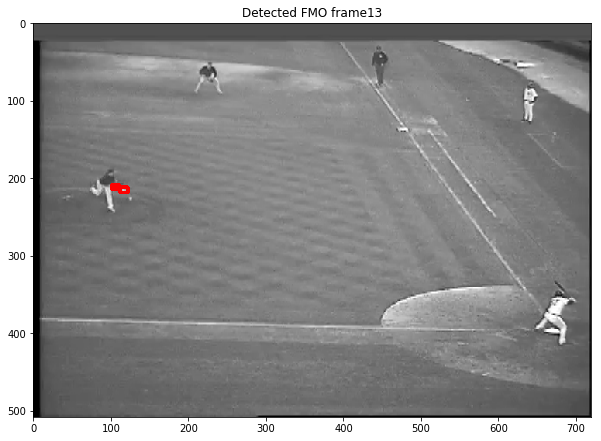

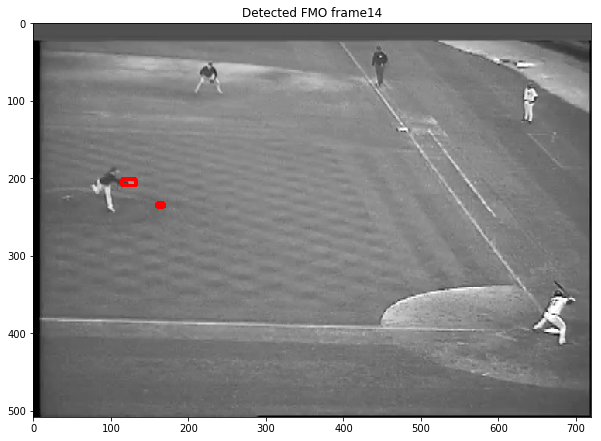

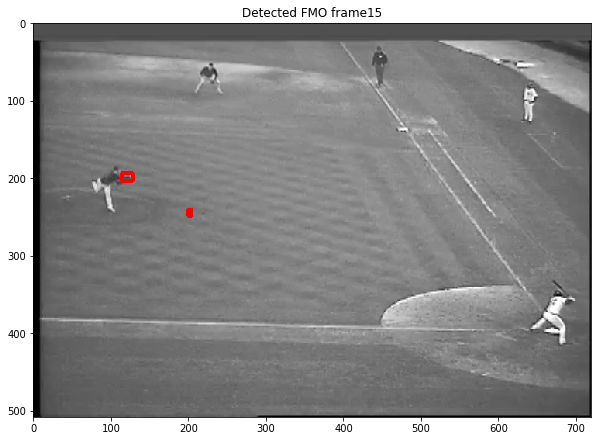

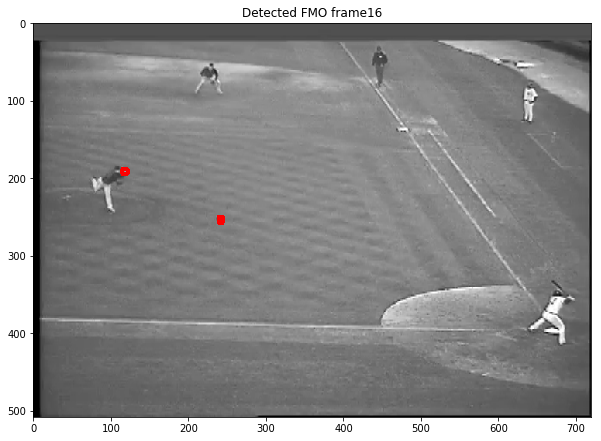

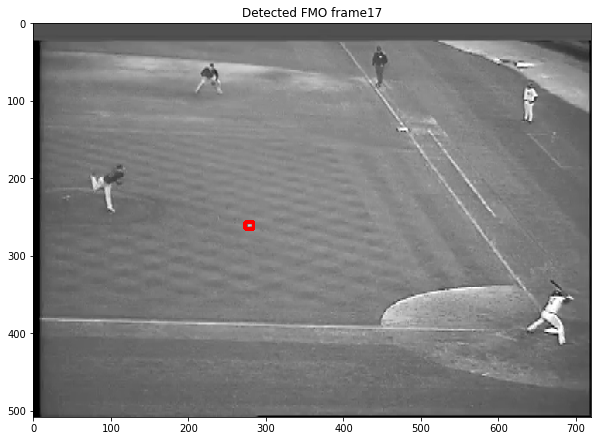

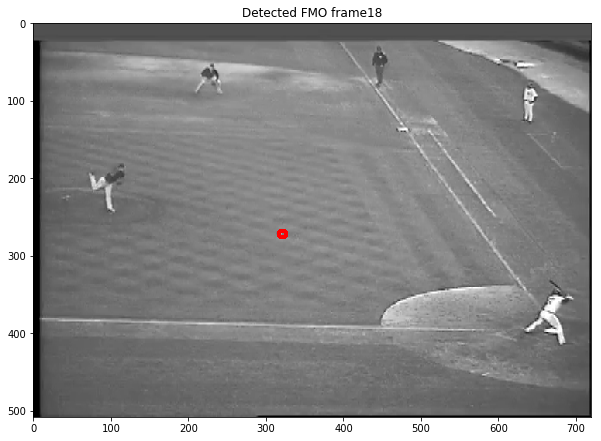

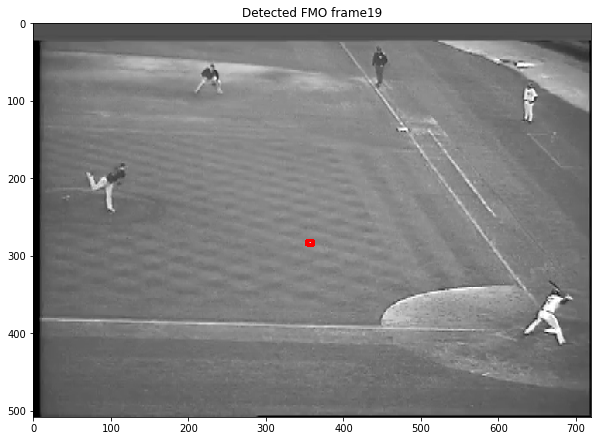

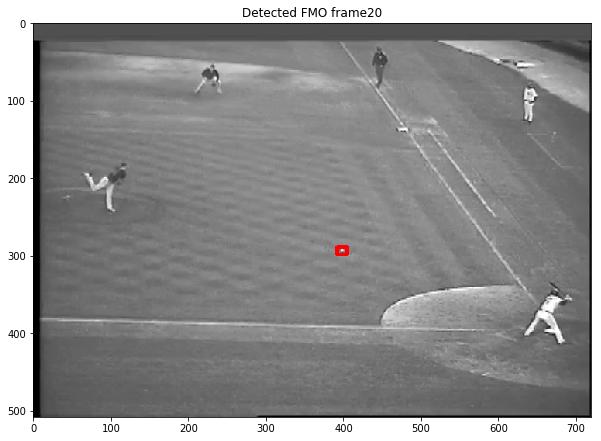

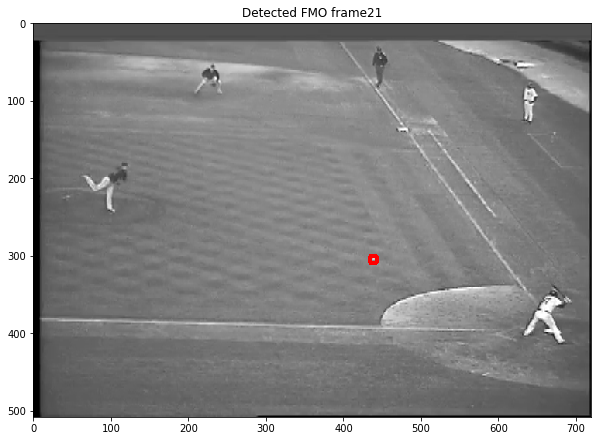

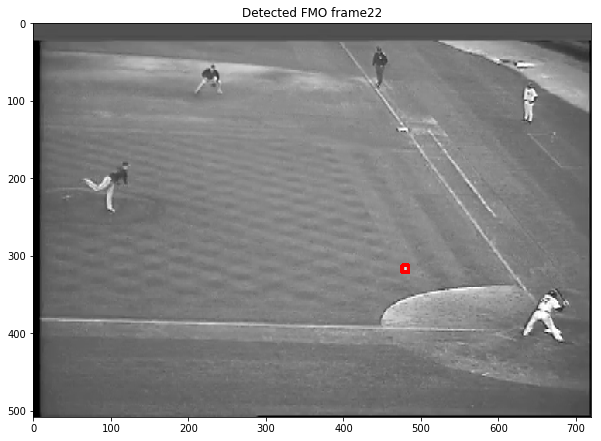

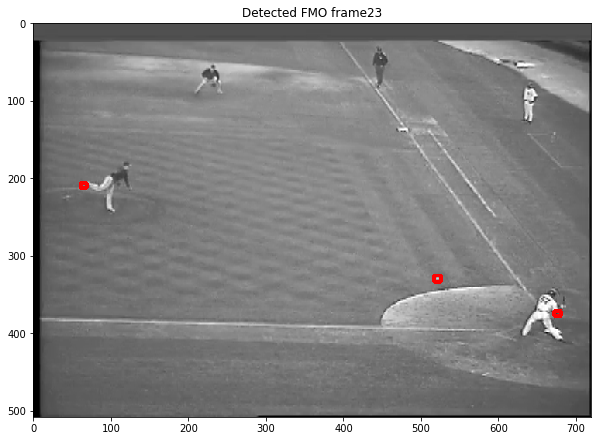

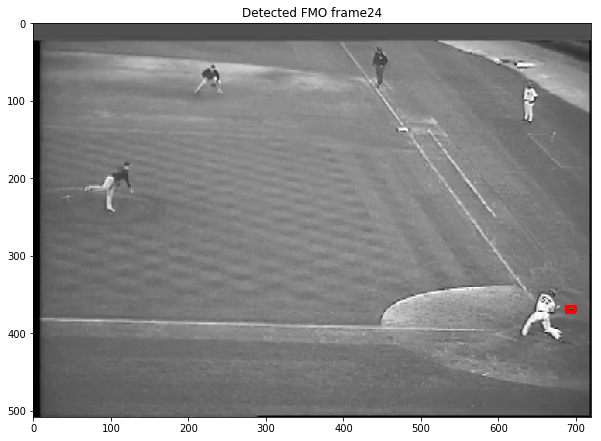

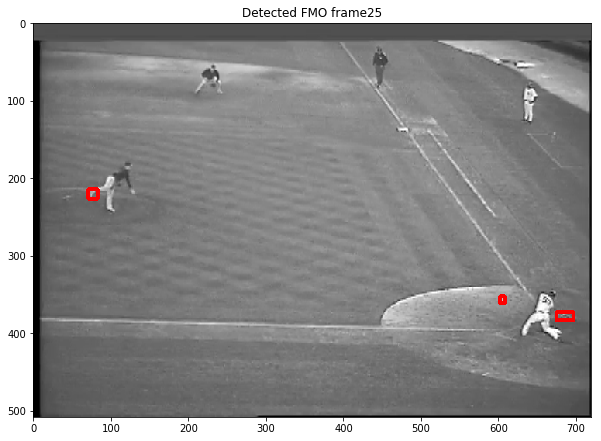

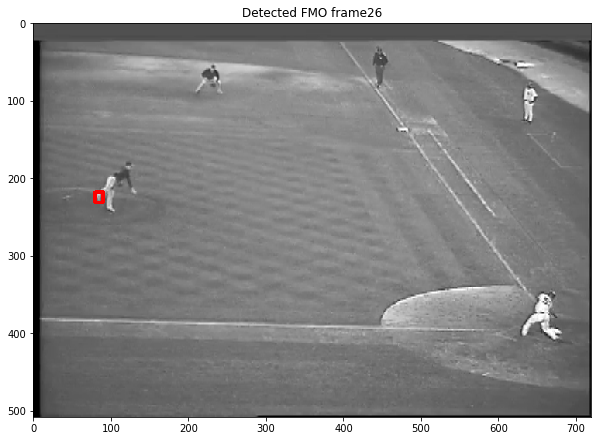

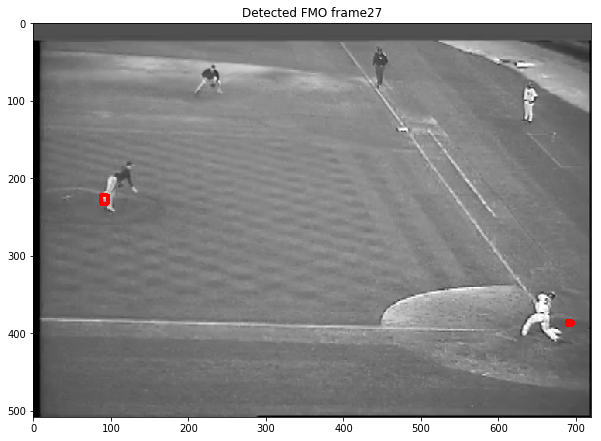

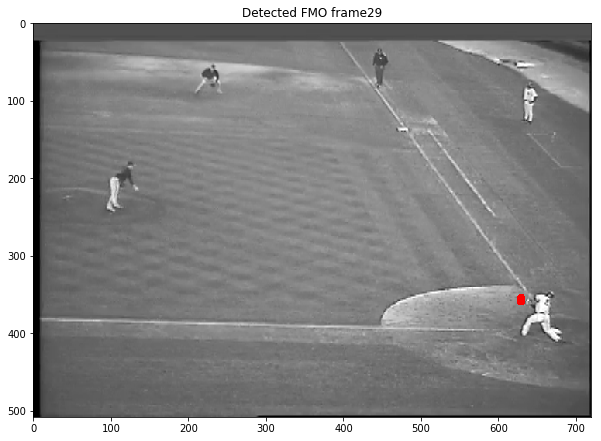

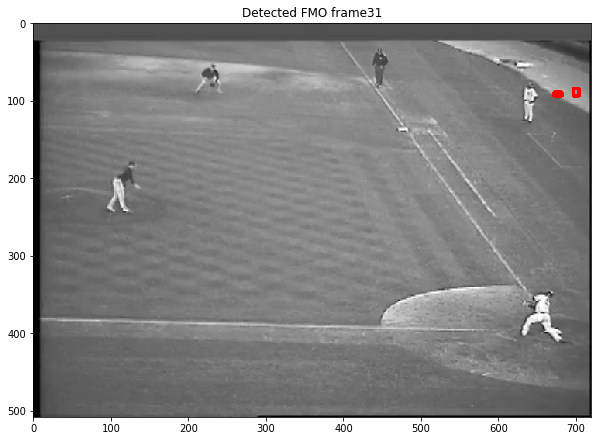

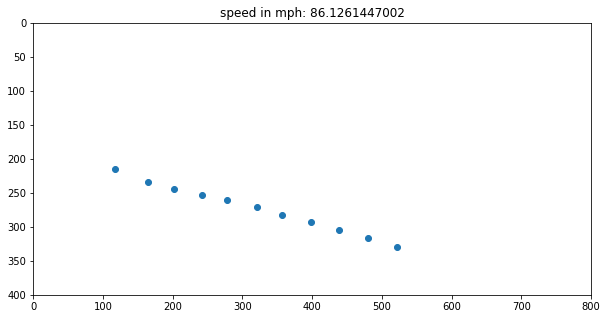

ball Trajectory [[117.0, 214.5, 12.0], [164.0, 234.5, 13.0], [202.0, 244.0, 14.0], [242.0, 253.0, 15.0], [278.5, 260.5, 16.0], [321.5, 271.5, 17.0], [357.0, 283.0, 18.0], [398.5, 293.0, 19.0], [438.5, 304.5, 20.0], [480.0, 316.5, 21.0], [521.5, 329.0, 22.0]]
/Users/ninawiedemann/Desktop/PITCHfx video/220317/camera_b.mp4


KeyboardInterrupt: 

In [107]:
# 1: /video/mlbam/2016/10/01/umpeval/video/449267/160930_193828
# 2: 449253/160930_190849
# PITCHfx video
path = "/Users/ninawiedemann/Desktop/PITCHfx video/"
dire = os.listdir(path)
counter = 0
for fi in ["220317"]: #dire:
    if len(fi)!=6:
        continue
    with open(path+fi+".json", "r") as infile:
            dic1 = json.load(infile)
    print(fi)    
    dic = {}
    dic["link"] = "http://ze-video.mlb.com/video/mlbam/2016/10/01/umpeval/video/449253/160930_"+fi
    for camera in ["a", "b", "c"]:
        try:
            if dic1["camera_"+camera]!={}:
                dic["camera_"+camera] = dic1["camera_"+camera]
                # continue
        except:
            pass
        BASE = path+fi+"/camera_"+camera+".mp4"
        print(BASE)
        ball_release, ball_trajectory, first_move_frame = detect_ball(BASE, joints_array = None, plotting=True, min_area=20) #400
        if len(ball_trajectory)==0:
            dic["camera_"+camera]={}
            print("NO DETECTION FOR", fi, camera)
            counter+=1
        else:
            ret, img = cap.read()
            trajectory_and_speed(ball_trajectory)
            print("ball Trajectory", ball_trajectory.tolist())
            inner_dic = {}
            for ball in ball_trajectory:
                inner_dic["frame "+str(ball[2])] = {"x":ball[0], "y": ball[1]}
            dic["camera_"+camera] = inner_dic
    print(counter)
    #with open(path+fi+".json", "w") as outfile:
     #   json.dump(dic, outfile)


In [ ]:
BASE = "/Volumes/Nina Backup/high_quality_testing/batter/#33 Logan Trowbridge.mp4" #"/Volumes/Nina Backup/high_quality_testing/pitcher/#42 LHP Michael Chavez.mp4" #"willites_test.mp4"
print(os.path.exists(BASE))
cap = cv2.VideoCapture(BASE)
ret, frame = cap.read()
ball_release, ball_trajectory, first_move_frame = detect_ball(BASE, joints_array = None, plotting=True, min_area=400) #400

In [ ]:
import urllib
import urllib.request

import re

url = "http://ze-video.mlb.com/video/mlbam/2016/10/01/umpeval/video/449253/"

urllist = re.findall(r"""<\s*a\s*href=["']([^=]+)["']""", urllib.request.urlopen(url).read().decode("utf-8"))

print(urllist[1:])

for i in urllist[1:]:
    link = "http://ze-video.mlb.com/video/mlbam/2016/10/01/umpeval/video/449253/"
    new_dir = "/Users/ninawiedemann/Desktop/PITCHfx video/"+str(i)[-7:-1]
    print(new_dir)
    if not os.path.exists(new_dir):
        os.makedirs(new_dir)
    else:
        continue
    
    for camera in ["a","b","c"]:
        path = "/Users/ninawiedemann/Desktop/PITCHfx video/"+str(i)[-7:-1]+"/camera_"+camera+".mp4"
        in_path = link+i+"camera_"+camera+".mp4"
        print(path, in_path)
        urllib.request.urlretrieve(in_path, path)

http://ze-video.mlb.com/video/mlbam/2016/10/01/umpeval/video/449253/160930_215045
[[ 368.   251.5   16. ]
 [ 502.5  288.5   19. ]
 [ 645.   330.    22. ]
 [ 199.5  204.5   12. ]
 [ 325.5  239.5   15. ]
 [ 412.   263.    17. ]
 [ 549.   302.    20. ]
 [ 281.   228.    14. ]
 [ 457.5  276.    18. ]
 [ 241.   216.    13. ]
 [ 157.   193.5   11. ]
 [ 597.5  316.5   21. ]]


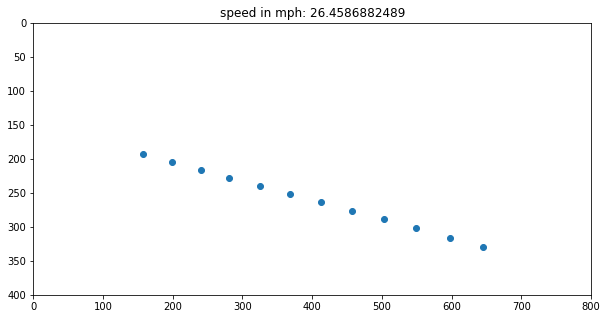

[[ 407.   280.5   15. ]
 [ 360.5  288.5   16. ]
 [ 171.   324.5   20. ]
 [ 220.   315.    19. ]
 [ 452.5  272.5   14. ]
 [ 268.   306.    18. ]
 [ 496.5  266.    13. ]
 [ 314.   297.    17. ]
 [ 540.5  259.5   12. ]
 [ 587.   252.5   11. ]
 [  95.   340.    21. ]]


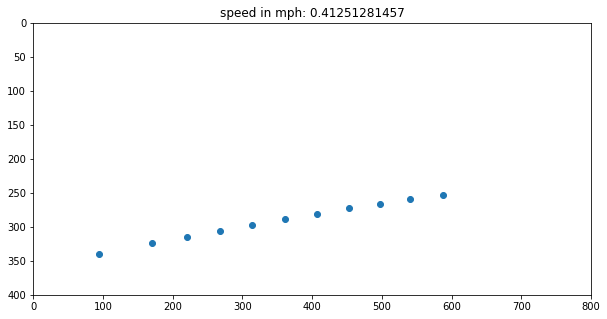

[[ 396.5  249.5   12. ]
 [ 377.5  235.    13. ]
 [ 414.5  261.5   11. ]]


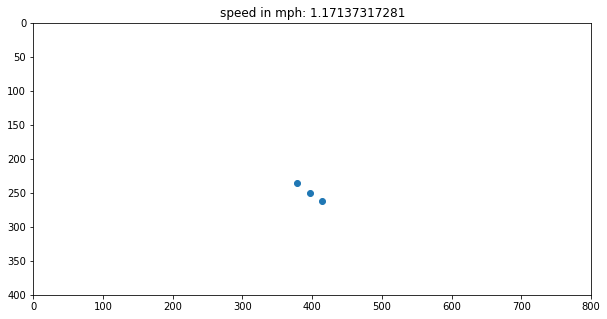

In [8]:
path = "/Users/ninawiedemann/Desktop/PITCHfx video/"
dire = os.listdir(path)
for fi in ["215045.json"]: #dire:
    if fi[-5:]!=".json":
        continue
    with open(path+fi, "r") as infile:
        dic = json.load(infile)
    print(dic["link"])
    for camera in ["a","b", "c"]:
        dic2 = dic["camera_"+camera]
        ball_trajectory = []
        for key in dic2.keys():
            ball_trajectory.append([dic2[key]["x"], dic2[key]["y"], int(float(key[-4:]))])
        ball_trajectory = np.array(ball_trajectory)
        print(ball_trajectory)
        trajectory_and_speed(ball_trajectory)

(1080, 1920, 3)
first movement frame:  154
Refined first movement 155
average candidates 0.666666666667
insgesamt 0.205527555375
für ball 0.15000656799
first move 0.033179870989
132 [[ 1272.5   757.5   160. ]
 [ 1233.5   766.    161. ]
 [ 1184.    770.5   162. ]
 [ 1478.5   714.5   162. ]
 [ 1264.    760.5   163. ]
 [ 1033.5   826.    164. ]] 155
0.26149445414543154


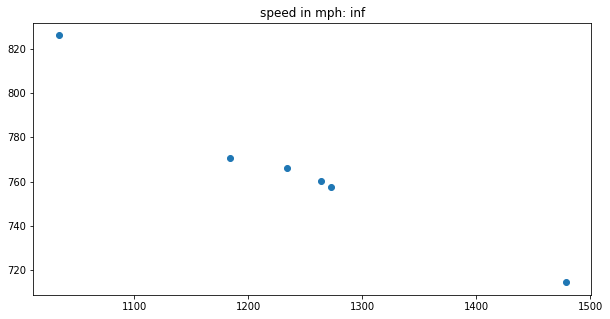

'\nif t==175:\n    print(t)\n    plt.figure(figsize=(10, 10))\n    plt.imshow(nd)\n    plt.axis("off")\n    plt.gray()\n    plt.savefig("thresholded_difference.png",bbox_inches=\'tight\')\n    plt.show()\n    plt.figure(figsize=(10, 10))\n    plt.imshow(final_frame)\n    plt.axis("off")\n    plt.savefig("shakiness_removed.png",bbox_inches=\'tight\')\n    plt.show()'

In [32]:
BASE = "/Volumes/Nina Backup/Nina's Pitch/cloudy.avi"
BASE = "/Volumes/Nina Backup/high_quality_testing/pitcher/#9 RHP Ryan King (2).mp4"
joints = from_json("/Volumes/Nina Backup/high_quality_outputs/#9 RHP Ryan King (2).json")
tic = time.time()
ball_release, ball_trajectory, first_move_frame = detect_ball(BASE, joints_array = joints, plotting=False, min_area=400, every_x_frame=3) #400
toc = time.time()
print(ball_release, ball_trajectory, first_move_frame)
print((toc-tic)/200)

trajectory_and_speed(ball_trajectory)
"""
if t==175:
    print(t)
    plt.figure(figsize=(10, 10))
    plt.imshow(nd)
    plt.axis("off")
    plt.gray()
    plt.savefig("thresholded_difference.png",bbox_inches='tight')
    plt.show()
    plt.figure(figsize=(10, 10))
    plt.imshow(final_frame)
    plt.axis("off")
    plt.savefig("shakiness_removed.png",bbox_inches='tight')
    plt.show()"""

In [ ]:
sv = pd.read_csv("/Users/ninawiedemann/Desktop/UNI/Praktikum/ALL/train_data/sv_data.csv")

In [ ]:
path = "/Volumes/Nina Backup/videos/atl/2017-05-22/side view/"

box = [400, 800, 600, 1400]
l = os.listdir(path)
speed_error = []
no_start_speed = 0
j=0
for BASE in l:
    if BASE[-4:]!=".m4v":
        continue
    line = sv[sv["Game"]==BASE[:-4]]
    if len(line["Regular Speed (P)"].values)==0:
        continue
    print("------------------------------------------------------------------------")
    label_speed = line["Regular Speed (P)"].values[0]
    print("STATCAST SPEED", label_speed)
    print("video:", BASE)
    ball_release, ball_trajectory, first_move_frame = detect_ball(path+BASE, joints_array = None, plotting=False, min_area=30, roi = box) #400
    j+=1
    if len(ball_trajectory)>0:
        #print(ball_release)
        #print(ball_trajectory)
        mean_speed = trajectory_and_speed(ball_trajectory)
        start_speed = trajectory_and_speed(ball_trajectory[:3], plotting=False)
        print("MEAN SPEED", mean_speed, "START SPEED", start_speed)
        if ball_trajectory[0,2]- ball_release < 2:
            speed_error.append(start_speed - label_speed)
        else:
            no_start_speed+=1
    print("data example", j, "errors", speed_error, "length errors", len(speed_error), "no start speed", no_start_speed)

print("mean error", np.mean(np.absolute(speed_error)))
print("MSE", np.mean(np.asarray(speed_error)**2))
print("proportion no start speed found: ", no_start_speed/float(j-1))
    #print(" RELEASE FRAME FOUND", first_move_frame)
    #if first_move_frame ==0:
     #   print("NO BALL TRAJECTORY FOUND")
    #plt.plot(ball_trajectory[:,0], ball_trajectory[:,1])
    #plt.ylim(400,0)
    #plt.show()
#example ="#9 RHP Ryan King (2)" # #9 RHP Ryan King (2) #9 RHP Ryan King # #48 RHP Tom Flippin # 8 RHP Cole Johnson #15 Brandon Coborn # #10 Matt Glomb #26 RHP Tim Willites" (willites camera moves) #00 RHP Devin Smith
#BASE = "/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/pitcher/"+example+".mp4" #"data/Matt_Blais/" # für batter: pic davor, 03 streichen und (int(idx+1))
#joints_path = "/Volumes/Nina Backup/high_quality_outputs/"+example+".json"

# First Movement testing

In [ ]:
import ast
#joints_path = "/Volumes/Nina Backup/Nina's Pitch/40mph_1us_1.2f_170fps_40m_sun.json"
path = "/Volumes/Nina Backup/CENTERFIELD bsp videos/"
# csv = pd.read_csv("/Users/ninawiedemann/Desktop/UNI/Praktikum/csvs/csv_gameplay.csv", delimiter = ";")
detected_first_move = []
label_first_move = []
label_release_frame =[]
j = 0
for bsp in os.listdir(path):
    if bsp[-4:]!=".mp4":
        continue
    BASE = path+ bsp # "/Volumes/Nina Backup/CENTERFIELD bsp videos/3d69a818-568e-4eef-9d63-24687477e7ee.mp4" # minarea 50
    print(bsp)
    joints_path = "/Volumes/Nina Backup/outputs/new_videos/cf/490770_"+ bsp[:-4] + "_pitcher.json" #3d69a818-568e-4eef-9d63-24687477e7ee_pitcher.json"
    if not os.path.exists(joints_path):
        print("file existiert nicht", joints_path)
        continue
    joints = from_json(joints_path)[:,:12,:]
    print(joints.shape)
    
    for i in open(BASE+".dat").readlines():
        datContent=ast.literal_eval(i)
    label_release_frame.append(datContent["pitch_frame_index"])
    label_first_move.append(datContent["first_movement_frame_index"])
    #assert dic["label"][j] == label_first_move[-1]
    #if dic["position"][j]!= "Windup":
     #   j+=1
    #  continue
    #print(dic["position"][j])
    j+=1
    #for name in ["40mph_1us_1.2f_170fps_40m_sun.avi","40mph_10us_6f_100fps_40m_cloudy.avi", "40mph_10us_11f_100fps_noisy.avi"]:
    #    frame_indizes, location, candidates_per_frame = detect_ball("/Volumes/Nina Backup/Nina's Pitch/"+name, joints_array=None)
    #import sys
    #sys.exit()
    frame_indizes, candidates_per_frame, first_move_frame = detect_ball(BASE, joints_array = joints, plotting=False, min_area=50, every_x_frame=3) #400
    detected_first_move.append(first_move_frame)
    
    # print("detected", detected_first_move[-1], "label", label_first_move[-1])
    
    
## FIRST MOVEMENT QUALITATIVE EVALUATION:
"""
        if first_move_found and joints_array is not None:
            if first_move_frame+2 >= t:
                print(first_move_frame, t)
                images = np.roll(np.array(images), -1, axis=0)
                images[-1] = frame
                t+=1
                continue
            else:
                diff = t-first_move_frame
                try:
                    show_frames = [images[-diff], images[-diff+1], images[-diff+2]]
                except IndexError:
                    print("PROBLEM: NOT ENOUGH FRAMES SAVED")
                    show_frames = [images[0], images[1], images[2]]
                    diff = 10
                fig = plt.figure(figsize=(10, 5))
                for ind, i in enumerate(show_frames):
                    ax = fig.add_subplot(1,len(show_frames),ind+1)
                    plt.imshow(i[100:400, 200:600])
                    plt.title("frame "+str(t-diff+ind))
                    plt.grid(False)
                    plt.axis('off')
                    plt.gray()
                plt.tight_layout()
                plt.show()
                plt.savefig("qualitative_first_move_3_refined/"+folder.split("/")[-1][:-4]+".png")
                break


        # HERE INSERT FIRST MOVE QUALITATIVE EVALUATION
        if first_move_found and joints_array is not None:
            print(first_move_frame, t)
            if first_move_frame+3 >= t:
                print(first_move_frame, t)
                images = np.roll(np.array(images), -1, axis=0)
                images[-1] = frame
                t+=1
                continue
            else:
                diff = t-first_move_frame
                try:
                    show_frames = [images[-diff-3], images[-diff], images[-diff+3]]
                    titles = ["Frame "+str(t-diff-3), "First move frame "+str(t-diff), "Frame "+str(t-diff+3)]
                except IndexError:
                    print("PROBLEM: NOT ENOUGH FRAMES SAVED")
                    show_frames = [images[0], images[1], images[2]]
                    diff = 10
                    break
                fig = plt.figure(figsize=(10, 5))
                for ind, i in enumerate(show_frames):
                    ax = fig.add_subplot(1,len(show_frames),ind+1)
                    plt.imshow(i[100:400, 200:600])
                    plt.title(titles[ind])
                    plt.grid(False)
                    plt.axis('off')
                    plt.gray()
                plt.tight_layout()
                plt.savefig("saved_every_third/"+folder.split("/")[-1][:-4]+".png")
                plt.show()
                break
"""

### ONLY DETECTION

In [ ]:
def polyarea_bbox(bbox):
    x = bbox[:,0]
    y = bbox[:,1]
    # print("Pearson", stats.pearsonr(x,y))
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def poly_factor(bbox):
    x = bbox[:,0]
    y = bbox[:,1]
    # print("Pearson", stats.pearsonr(x,y))
    area = 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))
    length = np.linalg.norm(bbox[0,:2]-bbox[2,:2])
    print(area, length)
    return length/(area+0.0000001)

def overlap(box1, box2):
    if box1[0]> box2[2] or box2[0]>box1[2] or box1[1]>box2[3] or box2[1]>box1[3]:
        return False
    else: return True

def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

out = np.array([[1098, 867, 1139, 905], [1074, 870, 1114, 908], [1050, 873, 1089, 911]])
x = out[:,[0, 2]].flatten()
y = out[:,[1,3]].flatten()
plt.scatter(x,y)
plt.show()
print(PolyArea(x,y))
print(np.linalg.norm(out[0,:2]-out[2,:2]))
print(overlap([1113, 617, 1146, 645], [1014, 655, 1047, 672]))

# first movement evaluation

### open json file with all results and csv with standard deviations

In [ ]:
import pandas as pd
with open("all_first_move_tests.json", "r") as infile:
    dic = json.load(infile)
print(dic.keys())
df = pd.read_csv("first_move_evaluation.csv")
print(df.columns.tolist())
print(df["Unnamed: 0"])

### save recent output in dictionary

In [ ]:
a = detected_first_move.copy()
b = label_release_frame.copy()[:-1]
c = label_first_move.copy()
print(len(a),len(b),len(c))
assert(c==dic["label"])
d = np.array([a,b,c])
print(d.shape)

np.save("first_move_outputs_every_3_ref_without_gradient.npy", a)

dic["3_refined_nograd"]= np.array(a).astype(np.float32).tolist()
with open("all_first_move_tests.json", "w") as outfile:
    json.dump(dic, outfile)

### histograms of dictionary

In [ ]:
for i in list(dic.keys()):
    plt.hist(dic[i], bins=np.arange(120))
    plt.title(i)
    plt.show()

### form csv with standard deviations and outliers

In [ ]:
new_column = "3_refined_nograd"
new_column_values = dic[new_column]
a = np.round(np.mean(new_column_values),3)
b = np.round(np.std(new_column_values),3)
c = np.sum(np.absolute(new_column_values-np.mean(new_column_values)) > 3*b)/275
d = np.sum(np.absolute(new_column_values-np.mean(new_column_values)) > 2*b)/275
e = np.sum(np.absolute(new_column_values-np.mean(new_column_values)) > 1*b)/275
l = [e,d,c,b,a]
print(l)
d = pd.Series(l)
df["every_3_refined"]=d
print(df)
df.to_csv("first_move_evaluation.csv")

In [ ]:
# dic = {"every_2":[], "every_3":[], "every_4":[], "every_5":[], "label":[]}
#with open("all_first_move_tests.json", "r") as infile:
#    dic = json.load(infile)
dic["every_3_refined"] = dic.pop("3_refined_nograd")
dic_new = {}
for d in list(dic.keys()):
    if d=="release" or d== "position" or d=="3_refined":
        continue
    print(d)
    # rel_detect = np.array(d[1]-d[0])
    rel_detect = np.asarray(dic[d])
    mean = np.mean(rel_detect)
    std = np.std(rel_detect)
    more_than_2std = np.sum(np.absolute(rel_detect-np.mean(rel_detect))> 2*std)/len(rel_detect)
    more_than_3std = np.sum(np.absolute(rel_detect-np.mean(rel_detect))> 3*std)/len(rel_detect)
    #print(more_than_2std)
    # print(np.sum(more_than_2std))
    dic_new[d] = [mean, std, more_than_2std, more_than_3std]
    print(d, dic_new[d])

#d = outputs[1]
#rel_lab = np.array(d[1]-d[2])
#std_2 = np.std(rel_lab)
#more_than_2std_2 = np.absolute(rel_lab-np.mean(rel_lab))> 3*std_2
#print(np.sum(more_than_2std_2))
#dic["label"].append(np.mean(rel_lab))

# print(dic)

In [ ]:
"""
for key in dic_new.keys():
    new = []
    for i in range(len(dic_new[key])):
        new.append(round(dic_new[key][i], 4))
    dic_new[key] = new
    print(new)
print(dic_new)
"""
df = pd.DataFrame.from_dict(dic_new)
df = df.round(2)
df = df.rename(index = {0: "mean", 1:"std",2: "percentage >2*std", 3: "percentage >3*std" })
df = df.rename(columns = {"3_refined_nograd": "every_3_refined"})
print(df.columns.tolist())
df.to_csv("first_move_evaluation.csv")
#with open("dic_with_first_move_evaluation.json", "w") as outfile:
 #   json.dump(dic, outfile)

### For position and gradient retrieval

In [ ]:
arr = np.array(outputs[2])
j=0
#old = pd.read_csv("/Users/ninawiedemann/Desktop/UNI/Praktikum/ALL/cf_data_cut.csv")
cf_list = old["Pitching Position (P)"].values
print(cf_list)
position  = []
cf_play_list = old["play_id"].values.tolist()
refined = []
for bsp in (os.listdir(path)):
    if bsp[-4:]!=".mp4":
        continue
    BASE = path+ bsp # "/Volumes/Nina Backup/CENTERFIELD bsp videos/3d69a818-568e-4eef-9d63-24687477e7ee.mp4" # minarea 50
    # print(bsp)
    joints_path = "/Volumes/Nina Backup/outputs/new_videos/cf/490770_"+ bsp[:-4] + "_pitcher.json" #3d69a818-568e-4eef-9d63-24687477e7ee_pitcher.json"
    if not os.path.exists(joints_path):
        print("file existiert nicht", joints_path)
        continue
    joints = from_json(joints_path)[:,:12,:]
    # print(joints.shape)
    
    #print(bsp, cf_play_list)
    if bsp[:-4] in cf_play_list:
        position.append(cf_list[cf_play_list.index(bsp[:-4])])
        # print(pos)
    else: 
        position.append("Unknown")
    continue
    
    for i in open(BASE+".dat").readlines():
        datContent=ast.literal_eval(i)
    rel_frame = datContent["pitch_frame_index"]
    label_first_move = datContent["first_movement_frame_index"]

    assert(rel_frame == arr[1,j])
    assert(label_first_move == arr[2,j])
    first_move_frame = arr[0,j]
    range_joints = joints[first_move_frame -10: first_move_frame +10]
    grad = np.gradient(range_joints, axis = 0)
    plt.plot(grad[:,:,1])
    #plt.show()
    mean_gradient = np.mean(grad[:, [7,8,10,11],1], axis = 1)
    plt.plot(mean_gradient, c = "black")
    plt.show()
    print("previous", first_move_frame, "new", first_move_frame-10+np.argmin(mean_gradient))
    refined.append(first_move_frame-10+np.argmin(mean_gradient))
    j+=1
    
print(position, len(position))

### plot comparisons

In [ ]:
# print(np.array(outputs).shape)
# new = np.array(outputs)[:, 0, :]
#new = np.append(np.array([outputs[0][1], outputs[0][2]]), np.array(new), axis = 0)
def scatter_plot(l):
    plt.scatter(np.arange(len(l[0])),l[0], label = "release frame index", c = "green")
    plt.scatter(np.arange(len(l[0])), l[1], label = "Statcast", c = "red")
    plt.scatter(np.arange(len(l[0])), l[2], label = "every 3rd refined", c="blue")

    
# COMPARE labels and 3 refined_nograd:
fig = plt.figure(figsize = (20,10))
scatter_plot([dic["release"], dic["label"], dic["3_refined_nograd"]])
# plt.title("label vs 3 refined - blue: refined, red: label")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0., fontsize=20)
plt.xlabel("Data example", fontsize=20)
plt.ylabel("frame index", fontsize=20)
plt.show()


# SHOW LABELS SEPERATED BY WINDUP AND STRETCH
inds = np.where(np.array(dic["position"])=="Windup")[0]
inds_st = np.where(np.array(dic["position"])=="Stretch")[0]
vals_wind = np.array(dic["label"])[inds]
vals_stretch = np.array(dic["label"])[inds_st]

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.hist(vals_wind, bins= np.arange(0, 110))
plt.title("windup")
plt.subplot(1,2,2)
plt.hist(vals_stretch, bins= np.arange(0, 110))
plt.title("stretch")
plt.show()

# WINDUP
every_3_wind = np.array(dic["every_3"])[inds]
every_4_wind =  np.array(dic["every_4"])[inds]
fig = plt.figure(figsize = (20,10))
# plt.style.use('ggplot')
plt.subplot(1,2,1)
scatter_plot([vals_wind, every_3_wind, every_4_wind])
plt.title("windup")
# plt.legend()
# plt.show()

# STRETCH
every_3_set = np.array(dic["every_3"])[inds_st]
every_4_set =  np.array(dic["every_4"])[inds_st]
# plt.style.use('ggplot')
plt.subplot(1,2,2)
scatter_plot([vals_stretch, every_3_set, every_4_set])
plt.title("stretch")
plt.legend()
plt.show()

# ALL
fig = plt.figure(figsize = (20,10))
# plt.style.use('ggplot')
scatter_plot([dic["label"], dic["every_3"], dic["every_4"]])
plt.legend()
plt.title("ALL")
plt.show()
#plt.grid(True)
#from matplotlib2tikz import save as tikz_save
#tikz_save('test.tex')

# COMPARE 3 and 3 refined_nograd:
fig = plt.figure(figsize = (20,10))
scatter_plot([dic["release"], dic["every_3"], dic["3_refined_nograd"]])
plt.title("3 vs 3 refined - blue: refined, red: normal3")
plt.show()



# DIFFERENCE FROM EACH OTHER
label_error = np.array(dic["3_refined"])-np.array(dic["every_3"])
plt.plot(label_error)
plt.show()
print(np.mean(label_error))

In [ ]:
for i in range(7):
    for j in range(275):
        new[i,j] = float(new[i,j])

#dic = {"release": new[0].tolist(), "label": new[1].tolist(), "every_2":new[2].tolist(), "every_3":new[3].tolist(), "every_4":new[4].tolist(), "every_5":new[5].tolist(), "3_refined":new[6].tolist()}
dic["position"] = position[:275]
with open("all_first_move_tests.json", "w") as outfile:
    json.dump(dic, outfile)

# Stabilization

In [ ]:
def optical_flow(file):
    cap = cv2.VideoCapture(file)
    arr = []
    # params for ShiTomasi corner detection
    feature_params = dict( maxCorners = 100,
                           qualityLevel = 0.3,
                           minDistance = 7,
                           blockSize = 7 )
    # Parameters for lucas kanade optical flow
    lk_params = dict( winSize  = (15,15),
                      maxLevel = 2,
                      criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    # Create some random colors
    color = np.random.randint(0,255,(100,3))
    # Take first frame and find corners in it
    ret, old_frame = cap.read()
    print(old_frame.shape)
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
    # Create a mask image for drawing purposes
    mask = np.zeros_like(old_frame)
    move = [0,0]
    for i in range(100): #while(1):
        ret,frame = cap.read()
        if frame is None:
            break
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # calculate optical flow
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
        # Select good points
        good_new = p1[st==1]
        good_old = p0[st==1]
        # draw the tracks
        for j,(new,old) in enumerate(zip(good_new,good_old)):
            a,b = new.ravel()
            c,d = old.ravel()
            mask = cv2.line(mask, (a,b),(c,d), color[j].tolist(), 2)
            frame = cv2.circle(frame,(a,b),5,color[j].tolist(),-1)
        img = cv2.add(frame,mask)
        move+= np.mean(good_new-good_old, axis = 0)
        mean_move = np.around(move).astype(int)
        print(np.mean(good_new-good_old, axis = 0))
        print(mean_move)
        if i>70:
            plt.imshow(img)
            plt.show()
        new = np.roll(frame, -mean_move[0], axis = 0)
        new = np.roll(new, -mean_move[1], axis = 1)
        arr.append(new[20:-20, 20:-20, :])
        #k = cv2.waitKey(30) & 0xff
        #if k == 27:
         #   break
        # Now update the previous frame and previous points
        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1,1,2)
    cv2.destroyAllWindows()
    cap.release()
    return np.array(arr)
    
example ="#9 RHP Ryan King (2)" #9 RHP Ryan King # #48 RHP Tom Flippin # 8 RHP Cole Johnson #15 Brandon Coborn # #10 Matt Glomb #26 RHP Tim Willites" (willites camera moves) #00 RHP Devin Smith
BASE = "/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/pitcher/"+example+".mp4" #"data/Matt_Blais/" # für batter: pic davor, 03 streichen und (int(idx+1))
array = optical_flow(BASE)
from skvideo import io
io.vwrite("stabilize.mp4", array)

# Person detector opencv

In [ ]:
# construct the argument parse and parse the arguments

 
# initialize the HOG descriptor/person detector
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

for imagePath in ["/Volumes/Nina Backup/Nina's Pitch/bsp_images/cloudy_ball.jpg"]:
    # load the image and resize it to (1) reduce detection time
    # and (2) improve detection accuracy
    image = cv2.imread(imagePath)
    image = imutils.resize(image, width=min(400, image.shape[1]))
    orig = image.copy()
    tic = time.time()
    # detect people in the image
    (rects, weights) = hog.detectMultiScale(image, winStride=(2, 2),
        padding=(4, 4), scale=1.09)
    print("time", time.time()-tic)
    # draw the original bounding boxes
    for (x, y, w, h) in rects:
        cv2.rectangle(orig, (x, y), (x + w, y + h), (0, 0, 255), 2)

    # apply non-maxima suppression to the bounding boxes using a
    # fairly large overlap threshold to try to maintain overlapping
    # boxes that are still people
    rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in rects])
    pick = non_max_suppression(rects, probs=None, overlapThresh=0.65)

    # draw the final bounding boxes
    for (xA, yA, xB, yB) in pick:
        cv2.rectangle(image, (xA, yA), (xB, yB), (0, 255, 0), 2)

    # show some information on the number of bounding boxes
    filename = imagePath[imagePath.rfind("/") + 1:]
    print("[INFO] {}: {} original boxes, {} after suppression".format(
        filename, len(rects), len(pick)))

    # show the output images
    plt.imshow(orig)
    plt.show()
    plt.imshow(image)
    plt.show()

In [ ]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)
def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))


In [ ]:
path = "/Volumes/Nina Backup/videos/atl/2017-05-22/side view/"
p1 = np.array([110, 140])
p2 = np.array([690, 288])
vec = (p2-p1)
print(vec, np.array([vec[1], vec[0]]))
p3 = (p1+0.1*np.array([-vec[1], vec[0]])).astype(int)
for BASE in os.listdir(path)[:1]:
    if BASE[-4:]!=".m4v":
        continue
    cap = cv2.VideoCapture(path+BASE)
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)[400:800, 600:1400]
    # frame[140, 110]=0   #[288, 690]=0 #280:290, 680:700] = 0
    frame = cv2.line(frame, tuple(p2), tuple(p1), color = 1)
    frame = cv2.line(frame, tuple(p1), tuple(p3), color = 1)
    plt.figure(figsize = (20,10))
    plt.imshow(frame)
    plt.gray()
    plt.show()

In [ ]:
distance = np.linalg.norm(np.array([140, 110])- np.array([288, 690]))
print(distance)


In [ ]:
p = np.array([300, 100])
dist = np.cos(angle_between(p-p1, p2-p1)) * np.linalg.norm(p-p1)
print(dist)
print(distance_projected(p, p1, p2))

In [ ]:
print(np.cross(np.array(690,288)-np.array(110, 140), np.array(110, 140)- np.array(300,500)))
#/np.linalg.norm(np.array(110, 140)-np.array(690,288))

In [ ]:
first_bbox = [-1,1]
second_bbox = [-2,2]
angle = np.arctan((first_bbox[1]-second_bbox[1])/(first_bbox[0]-second_bbox[0]))
print(angle)

In [ ]:
sv = pd.read_csv("/Users/ninawiedemann/Desktop/UNI/Praktikum/ALL/sv_data.csv")
rel = sv["pitch_frame_index"].values
print(np.unique(sv["pitch_frame_index"].values))
plt.hist(rel)